In [29]:
import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import os, sys
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

# find root directory and add to path
root_index = os.getcwd().rfind('notebooks')
root_directory = os.path.dirname(os.getcwd()[:root_index])
sys.path.append(root_directory)

from MotorNet.plants import RigidTendonArm
from MotorNet.plants.muscles import RigidTendonHillMuscleThelen
from MotorNet.utils.plotor import plot_pos_over_time
from MotorNet.nets.layers import GRUController
from MotorNet.nets.callbacks import BatchLogger, TrainingPlotter
from MotorNet.tasks import TaskStaticTarget, TaskDelayedReach, TaskDelayedMultiReach

from MotorNet.nets.custommodels import MotorNetModel

%load_ext autoreload
%autoreload 2

# tf.debugging.enable_check_numerics()
print('tensorflow version: ' + tf.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
tensorflow version: 2.3.0


n_t:  50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Input shape:  (10, 205, 5)
Target shape:  (10, 205, 4)


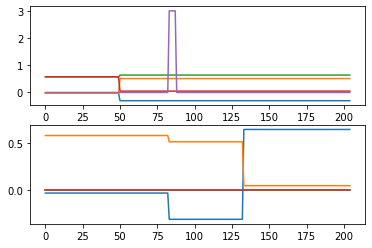

In [30]:
arm = RigidTendonArm(muscle_type=RigidTendonHillMuscleThelen(), proprioceptive_delay=0.04, visual_delay=0.13,
                     excitation_noise_sd=0.001)
feedback_noise = 0.001
# kernel 0, activity 0, recurrent 0
cell = GRUController(plant=arm, n_units=200, kernel_regularizer=10**-5, activity_regularizer=10**-4,
                     recurrent_regularizer=10**-6, name='cell',
                     proprioceptive_noise_sd=feedback_noise, visual_noise_sd=feedback_noise)

sho = np.random.uniform(20, 80, (100, 1))
elb = np.random.uniform(20, 80, (100, 1))
initial_joint_state = np.deg2rad(np.concatenate([sho, elb, np.zeros_like(sho), np.zeros_like(sho)], axis=-1))
task = TaskDelayedMultiReach(cell, initial_joint_state=initial_joint_state, delay_range=[30,50], num_target=2)

task.delay_range = [30,50]
task.variable_init = True
task.num_target = 2

n_t = int(.5 / arm.dt)
print('n_t: ', n_t)
[inputs, targets, init_states] = task.generate(n_timesteps=n_t, batch_size=10)
print("Input shape: ", inputs.shape)
print("Target shape: " , targets.shape)
fig, axs = plt.subplots(2,1)
axs[0].plot(inputs[0])
axs[1].plot(targets[0])
plt.show()

In [32]:
arm = RigidTendonArm(muscle_type=RigidTendonHillMuscleThelen(), proprioceptive_delay=0.04, visual_delay=0.13,
                     excitation_noise_sd=0.001)
feedback_noise = 0.001
# kernel 0, activity 0, recurrent 0
cell = GRUController(plant=arm, n_units=200, kernel_regularizer=10**-5, activity_regularizer=10**-4,
                     recurrent_regularizer=10**-6, name='cell',
                     proprioceptive_noise_sd=feedback_noise, visual_noise_sd=feedback_noise)

sho = np.random.uniform(20, 80, (100, 1))
elb = np.random.uniform(20, 80, (100, 1))
initial_joint_state = np.deg2rad(np.concatenate([sho, elb, np.zeros_like(sho), np.zeros_like(sho)], axis=-1))
task = TaskDelayedMultiReach(cell, initial_joint_state=initial_joint_state, delay_range=[30,50], num_target=2)
task.delay_range = [10,80]
task.num_target = 1
batch_size = 64


# declare inputs
targets = Input((None, arm.state_dim,), name='target')
inputs = Input((None, task.get_input_dim()))
state0 = [Input((arm.state_dim, ), name='joint0'),
          Input((arm.state_dim, ), name='cartesian0'),
          Input((arm.muscle_state_dim, arm.n_muscles, ), name='muscle0'),
          Input((arm.geometry_state_dim, arm.n_muscles, ), name='geometry0'),
          Input((arm.n_muscles*2, arm.proprioceptive_delay, ), name='proprio_feedback0'),
          Input((arm.space_dim, arm.visual_delay, ), name='visual_feedback0')]
state0.extend([Input((n, ), name='gru' + str(k) + '_hidden0') for k, n in enumerate(cell.n_units)])


# wrap cell in an RNN layer
states_out = tf.keras.layers.RNN(cell=cell, return_sequences=True, name='RNN')(inputs, initial_state=state0)
control_rnn = MotorNetModel(inputs=[inputs, state0], outputs=states_out, task=task, name='controller')

# pull the losses from the task itself
[losses, loss_weights] = task.get_losses()

# and compile
control_rnn.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001, clipnorm=1.), loss=losses, loss_weights=loss_weights)
batchlog_callback = BatchLogger()
trainingplot_callback = TrainingPlotter(task, plot_freq=100)
control_rnn.summary()
losses


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Model: "controller"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
joint0 (InputLayer)             [(None, 4)]          0                                      

{'cartesian position': <function MotorNet.nets.losses.position_loss.<locals>.loss(y_true, y_pred)>,
 'muscle state': <function MotorNet.nets.losses.activation_squared_loss.<locals>.loss(y_true, y_pred)>}

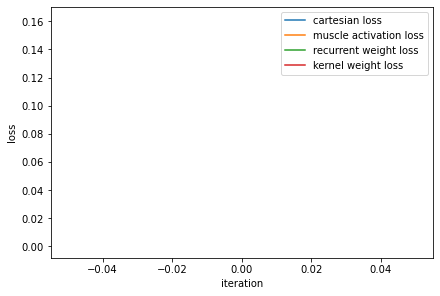

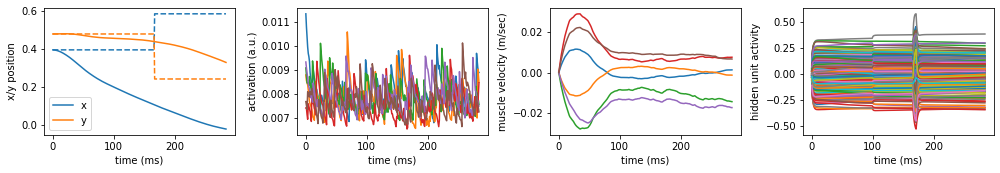

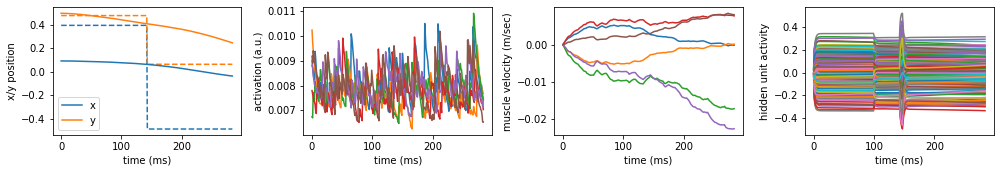

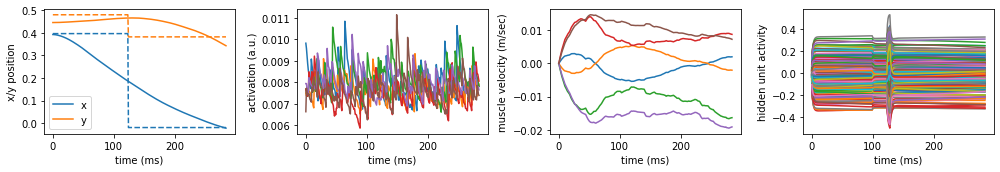

 6/30 [=====>........................] - ETA: 8s - loss: 0.1493 - RNN_loss: 0.1487 - RNN_4_loss: 7.1876e-05

KeyboardInterrupt: 

In [33]:
#name = '50gru_1e-3dt_weights'
#control_rnn.load_weights(os.getcwd() + '/saved_models/' + name)


batch_size = 64
dataset_size = 30 * batch_size
n_t = int(1 / arm.dt)

# Test A
# Work without specifying any initial joint state


# Test B
# This works
# task.initial_joint_state = np.deg2rad([90., 45., 0., 0.])


# Test C
# When removeing expland_dim from Task line 26, this should work!
#task.initial_joint_state = np.deg2rad(
#np.concatenate((
#np.random.uniform(low=arm.pos_lower_bound[0], high=arm.pos_upper_bound[0], size=(dataset_size, 1)),
#np.random.uniform(low=arm.pos_lower_bound[1], high=arm.pos_upper_bound[1], size=(dataset_size, 1)),
#np.zeros((dataset_size,2))
#    ), axis=1)
#)


with tf.device('/cpu:0'):
    for _ in range(1):
        [inputs, targets, init_states] = task.generate(batch_size=dataset_size, n_timesteps=n_t)
        control_rnn.fit([inputs, init_states], targets, epochs=1, batch_size=batch_size, verbose=1, callbacks=[batchlog_callback, trainingplot_callback], shuffle=False)

In [ ]:
[inputs, targets, init_states] = task.generate(batch_size=dataset_size, n_timesteps=n_t)

print(inputs.shape)
print(targets.shape)
test = [print(s.shape) for s in init_states]